# Analiza zbioru danych 🎹 Spotify Tracks Dataset

W tym notatniku zaprezentowana zostanie analiza zbioru dannych [🎹 Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset). Najpierw przeprowadzona zostanie wstępna eksploracyjna analiza danych, a następnie wytrenowane zostaną modele, które przewidywać będą gatunek muzyki dla danej piosenki na podstawie atrybutów dostępnych w zbiorze danych.

### Import niezbędnych bibliotek oraz pakietów

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Opis zbioru danych

## Wczytanie zbioru danych oraz wstępne przetwarzanie

Z całego zbioru danych zostaną wyfiltrowane tylko niektóre gatunki, które nie zależą od pochodzenia/narodowości twórcy oraz które są popularne.

In [2]:
GENRES = [
    'alternative', 'blues', 'chill', 'classical', 'country', 'dance', 
    'death-metal', 'disco', 'edm', 'electro', 'funk', 'hard-rock', 'hip-hop', 
    'indie', 'jazz', 'pop', 'reggae', 'rock-n-roll', 'rock', 'soul'
]
COLUMNS = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'track_genre']
COLUMNS_NUMERICAL = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
COLUMNS_NOMINAL = ['explicit', 'key', 'mode']

Przykładowe 5 próbek ze zbioru danych

In [3]:
df_original = pd.read_csv("data/dataset.csv", index_col=0)
df_original = df_original[df_original['track_genre'].isin(GENRES)]
df_original.sample(5, random_state=8000)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
91617,6vjQCBm2VUuImpkGNEywmL,Rod Stewart,On air 70's Hits,Maggie May,1,344586,False,0.5940,0.7190,2,-6.2120,1,0.0387,0.4810,0.0722,0.1240,0.4940,129.3370,4,rock
3213,2UREu1Y8CO4jXkbvqAtP7g,Skillet,Awake,Monster,77,178013,False,0.6400,0.9570,8,-2.3360,1,0.0741,0.0431,0.0000,0.0789,0.6920,134.9920,4,alternative
91307,1sWeSMifj6Z6kZyI6z3bRc,Imagine Dragons,Smoke + Mirrors (Deluxe),Warriors,75,171040,False,0.3650,0.8510,4,-6.2380,0,0.0645,0.0964,0.0030,0.2370,0.3090,78.0860,4,rock
51664,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937,False,0.6210,0.7820,2,-5.5480,1,0.0440,0.0125,0.0330,0.2300,0.5500,128.0330,4,hip-hop
37088,4RWsdetm3NxNWsI88bJ23y,Stevie Wonder,Weihnachtssongs,What Christmas Means To Me - Single Version / ...,0,148146,False,0.5450,0.7000,5,-6.9610,1,0.0323,0.0982,0.0000,0.1000,0.7990,83.5060,4,funk


## Opis zbioru danych

Zbiór danych posiada 20 atrybutów. Pogrubioną czcionką oznaczone zostały te, które będą używane w dalszej analizie danych oraz podczas uczenia modeli.
1. track_id - unikalny identyfikator utworu w ramach Spotify,
2. artists - zbiór artystów, którzy są autorami piosenki,
3. album_name - nazwa albumu, na którym pojawia się piosenka,
4. track_name - nazwa piosenki,
5. **popularity** - popularność piosenki wyrażona na skali od 0 do 100. Wyliczana jest ona na podstawie algorytmu przygotowanego przez Spotify, który bierze pod uwagę takie czynniki jak liczba odtworzeń utworu w serwisie oraz ich aktualności (czy utwór jest popularny teraz czy w przeszłości),
6. **duration_ms** - długość trwania pionseki w milisekundach,
7. **explicit** - wartość bool określająca czy piosenka posiada niecenzuralne słowa,
8. **danceability** - wartość od 0.0 do 1.0 określająca jak bardzo piosenka nadaje się do tańczenia. Wartość wyliczana jest między innymi na podstawie tempa czy też stabilności rytmu,
9. **energy** - wartość od 0.0 do 1.0 reprezentująca miarę intensywności utworu. Przykładowo piosenki, które są szybkie, głośne oraz hałaśliwe mają wysoką wartość energii,
10. **key** - tonacja, w której jest piosenka określona w notacji [Pitch class](https://en.wikipedia.org/wiki/Pitch_class),
11. **loudness** - średnia głośność piosenki wyrażona w decybelach,
12. **mode** - określenie czy piosenka jest w tonacji dur (1) czy moll (0),
13. **speechiness** - wartość od 0.0 do 1.0 odpowiadająca za obecność słów w piosence. Przykładowo poezja czytana albo podcast posiada wartość 1.0,
14. **acousticness** - wartość od 0.0 do 1.0 określająca jak bardzo akustyczny jest utwór,
15. **instrumentalness** - wartość od 0.0 do 1.0 określająca czy utwór zawiera słowa. Przykładowo piosenki, które są zaklasyfikowane jako Rap będą miały niską wartość instrumentalness. Im większa wartość tego atrybutu, tym większa pewność, że utwór nie posiada słów,
16. liveness - wartość od 0.0 do 1.0 określająca pewność z jaką utwór został wykonany na żywo,
17. **valence** - wartość od 0.0 do 1.0 określająca jak bardzo pozytywny jest utwór. Piosenki, które mają wartość 1.0 na tym atrybucie będą radosne, a z małymi wartościami (bliskimi 0.0) będą smutne,
18. **tempo** - średnia tempo utworu [BPM](https://en.wikipedia.org/wiki/Tempo),
19. time_signature - oszacowane taktowanie utworu,
20. **track_genre** - gatunek muzyki, do którego należy piosenka.

In [4]:
df = df_original[COLUMNS].copy()

# Mapping key to object and mode to bool
df['key'] = df['key'].astype('category')
df['mode'] = df['mode'].astype('bool')

df.dtypes

popularity             int64
duration_ms            int64
explicit                bool
danceability         float64
energy               float64
key                 category
loudness             float64
mode                    bool
speechiness          float64
acousticness         float64
instrumentalness     float64
valence              float64
tempo                float64
track_genre           object
dtype: object

Większość z rozważanych atrybutów jest typu int lub float, natomiast są również atrybuty nominalne takie jak: *explicit* przyjmująca wartość boolowską - Prawda lub Fałsz, *key* która mimo tego, że określana jako integer ma charakter kategoryczny (nie można powiedzieć że próbka przyjmująca wartość 1 jest na przykład gorsza/lepsza od próbki przyjmującej wartość 2 na tym atrybucie), *mode* przyjmująca wartość boolowską - Prawda jeżeli tonacja dur, Fałsz jeżeli tonacja moll.

In [5]:
df.isnull().values.any()

False

W przygotowanym zbiorze danych nie ma wartości brakujących.

In [6]:
df.describe()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
count,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000
mean,30.2781,211461.6429,0.5913,0.6203,-7.8853,0.0780,0.3166,0.0790,0.5159,119.4360
std,29.8967,82660.7470,0.1663,0.2369,4.6353,0.0782,0.3205,0.2257,0.2439,29.3755
min,0.0000,17453.0000,0.0000,0.0008,-41.5310,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,168810.0000,0.4800,0.4640,-9.3470,0.0353,0.0336,0.0000,0.3230,96.0690
50%,29.0000,200437.0000,0.6050,0.6520,-6.7150,0.0485,0.1840,0.0000,0.5170,118.7090
75%,59.0000,240020.7500,0.7140,0.8080,-4.9460,0.0828,0.5770,0.0020,0.7090,136.7413
max,100.0000,2959346.0000,0.9750,1.0000,1.8210,0.9050,0.9960,0.9840,0.9920,243.3720


W powyższej tabeli przedstawione zostały statystyki dotyczące każdego z atrybutów liczbowych. Można zauważyć, że dla niektórych modeli/klasyfikatorów trzeba będzie sprawdzić również wersję z normalizacją/standaryzacją danych, ponieważ istnieje duża różnica (parę rzędów wielkości) pomiędzy wartościami dla atrybutów np. duration_ms oraz acousticness.

In [7]:
print(f"Liczba próbek/przypadków: {len(df)}, liczba rozpatrywanych gatunków {len(GENRES)}")
print(f"Liczba gatunków, które mają 1000 przykładów: {((df.groupby('track_genre').count() == 1000).sum(axis=1) == len(COLUMNS)-1).sum()}")

Liczba próbek/przypadków: 20000, liczba rozpatrywanych gatunków 20
Liczba gatunków, które mają 1000 przykładów: 20


Każdy z rozpatrywanych gatunków ma 1000 przykładów.

# Interpretacja przypadków ze zbioru danych

W tej sekcji przedstawione zostaną trzy konkretne przypadki ze zbioru danych.

In [8]:
# df.loc[[81137, 19611, 16058], :]

In [9]:
# df_original.loc[[81137, 19611, 16058], ['artists', 'album_name', 'track_name']]

##### Black Space - Taylor Swift - pop



##### Ain't It Fun - Paramore - emo



##### Nocturne In C-Sharp Minor, Op. Posth. - Frédéric Chopin;Dang Thai Son	- classical



# Eksploracyjna analiza danych

## Analiza atrybutów numerycznych

### Rozkład dla poszczególnych atrybutów
Dla atrybutów, które przyjmują wartości ciągłe wyświetlone zostaną histogramy z "Kernel density estimate (KDE)".

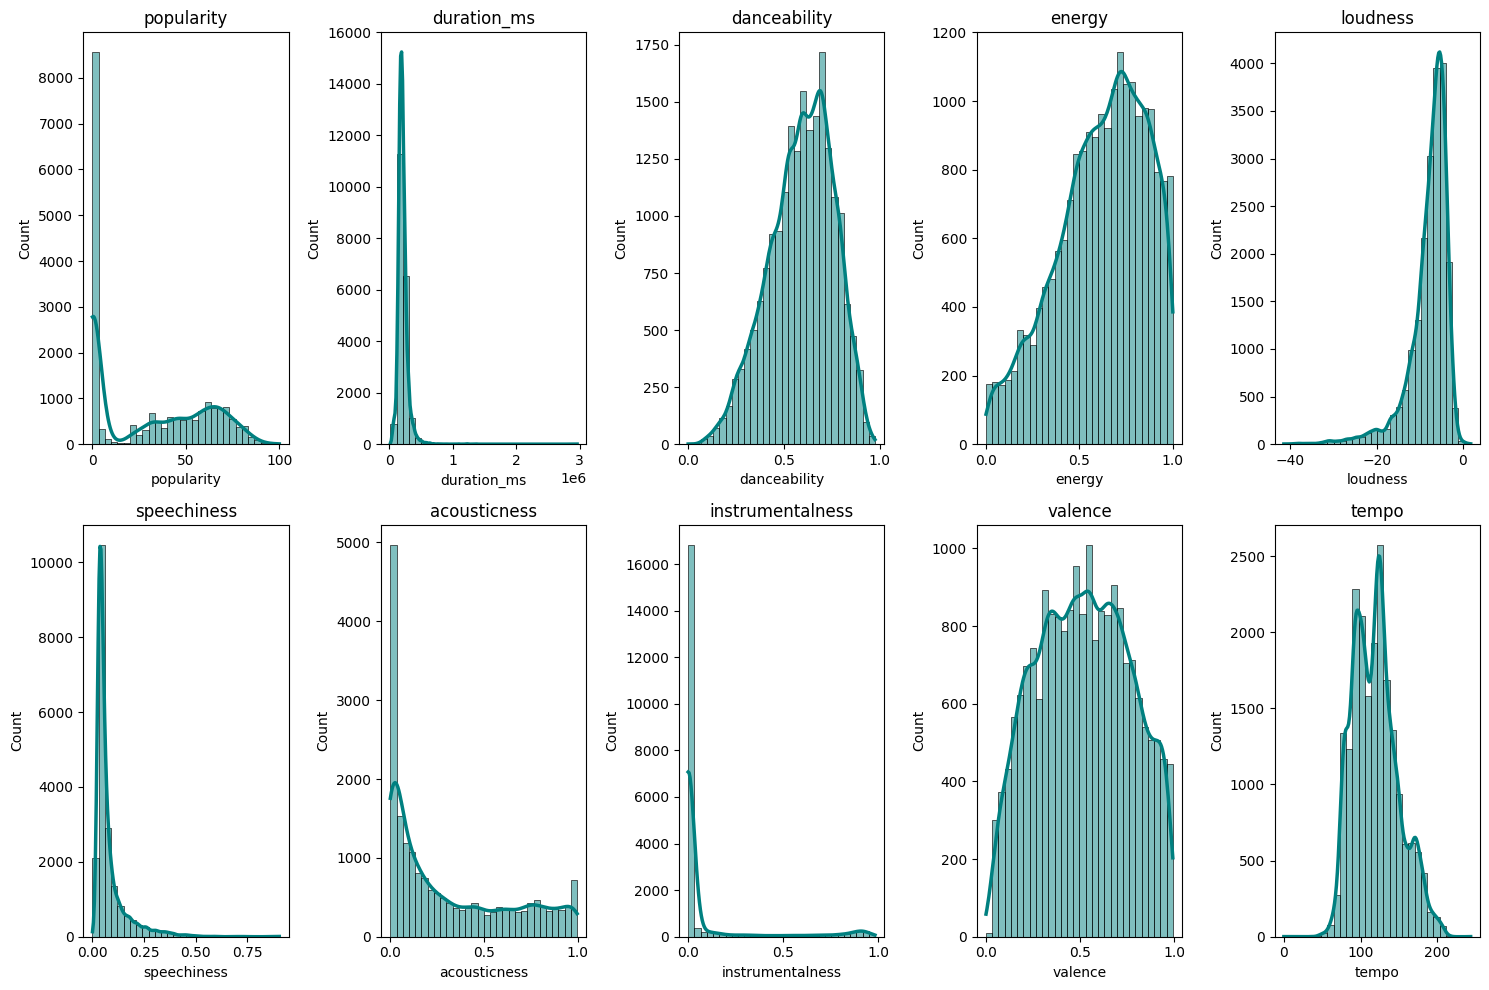

In [36]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(COLUMNS_NUMERICAL):
    plt.subplot(2, 5, i + 1)
    sns.histplot(data=df, x=column, bins=30, color='teal', kde=True, line_kws={'linewidth': 2.5})
    plt.title(column)
plt.tight_layout()
plt.show()

### Macierz korelacji

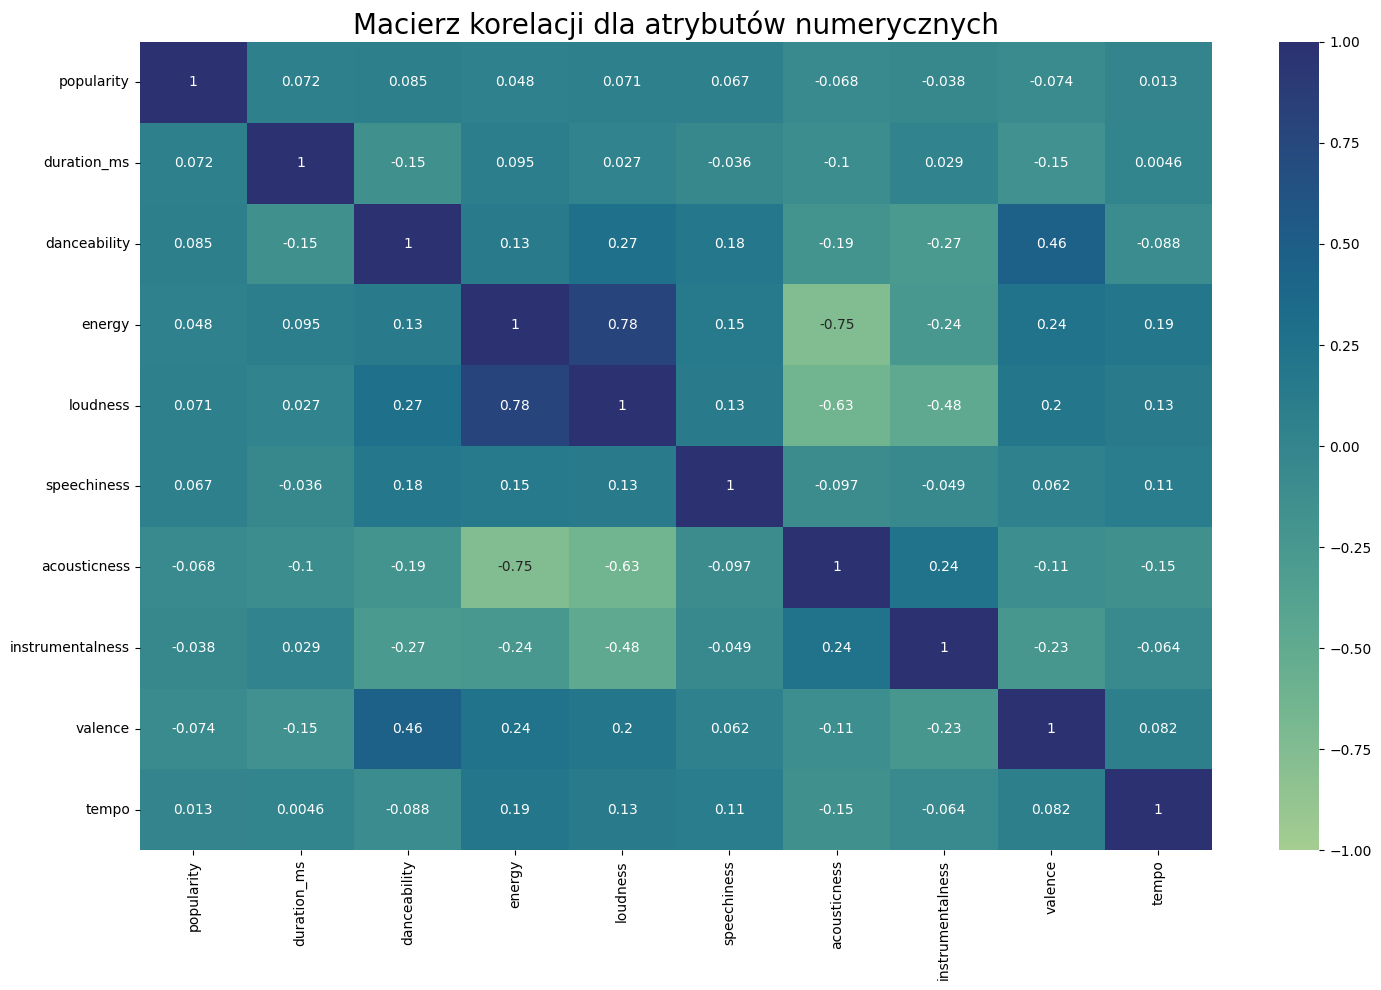

In [34]:
corr = df[COLUMNS_NUMERICAL].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='crest', vmin=-1, vmax=1)
plt.title("Macierz korelacji dla atrybutów numerycznych", fontsize=20)
plt.tight_layout()
plt.show()

## Analiza wartości numerycznych dla gatunków pop vs disco vs classical

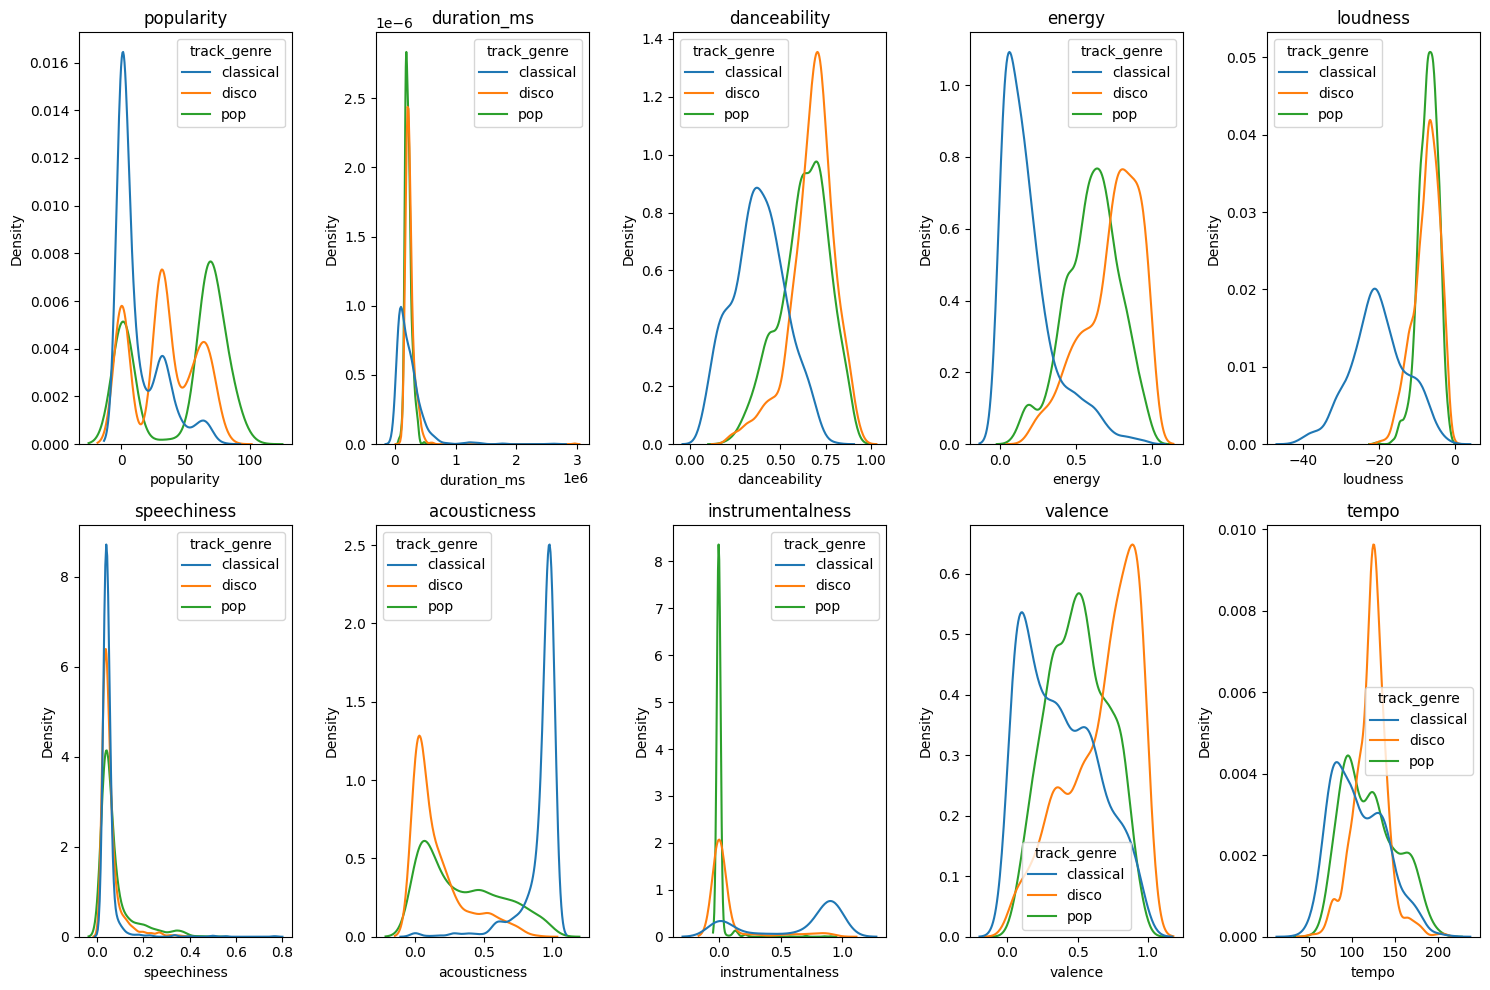

In [62]:
GENRES_COMPARISON = ['pop', 'disco', 'classical']
plt.figure(figsize=(15, 10))
for i, column in enumerate(COLUMNS_NUMERICAL):
    plt.subplot(2, 5, i + 1)
    sns.kdeplot(data=df[df['track_genre'].isin(GENRES_COMPARISON)], x=column, hue='track_genre')
    plt.title(column)
plt.tight_layout()
plt.show()

## Analiza wartości numerycznych dla gatunków country vs indie vs hip-hop

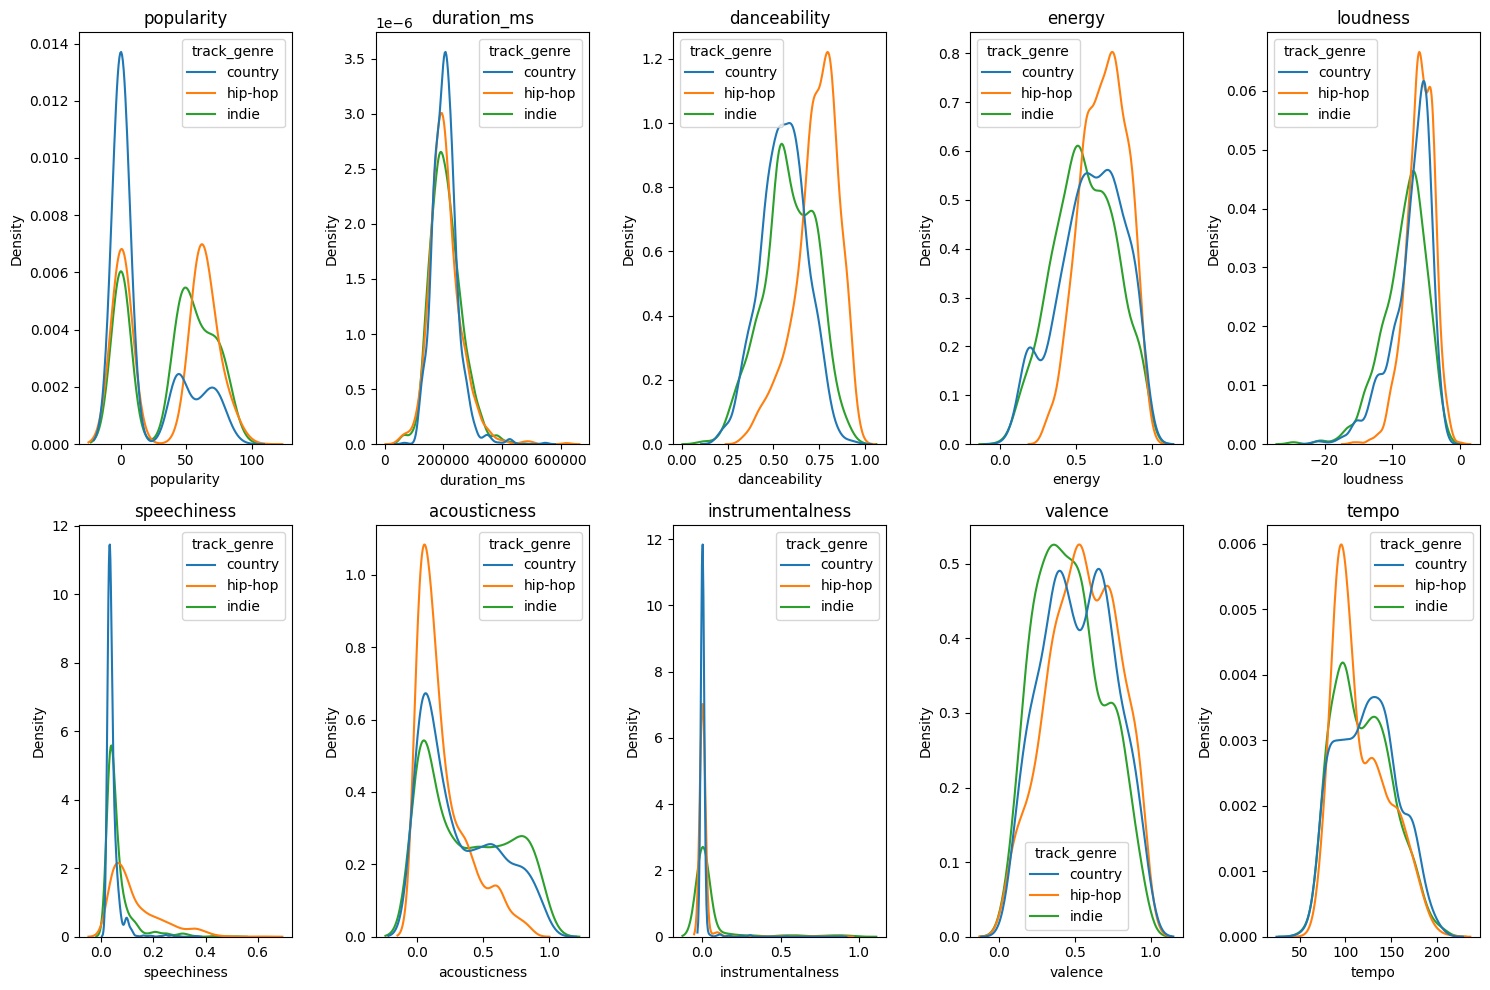

In [64]:
GENRES_COMPARISON = ['country', 'indie', 'hip-hop']
plt.figure(figsize=(15, 10))
for i, column in enumerate(COLUMNS_NUMERICAL):
    plt.subplot(2, 5, i + 1)
    sns.kdeplot(data=df[df['track_genre'].isin(GENRES_COMPARISON)], x=column, hue='track_genre')
    plt.title(column)
plt.tight_layout()
plt.show()

## Analiza atrybutów nominalnych

### Wykresy słupkowe

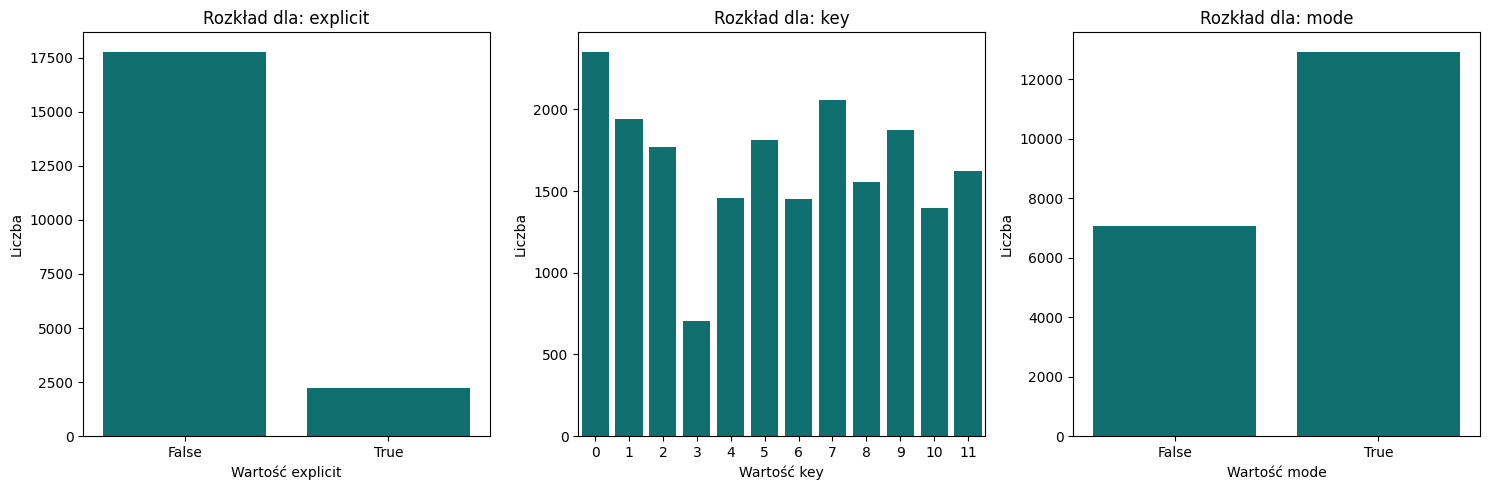

In [50]:
plt.figure(figsize=(15, 5))
for i, column in enumerate(COLUMNS_NOMINAL):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=df, x=column, color='teal')
    plt.title(f"Rozkład dla: {column}")
    plt.ylabel("Liczba")
    plt.xlabel(f"Wartość {column}")
plt.tight_layout()
plt.show()

### Analiza 'explicit' dla gatunków muzyki

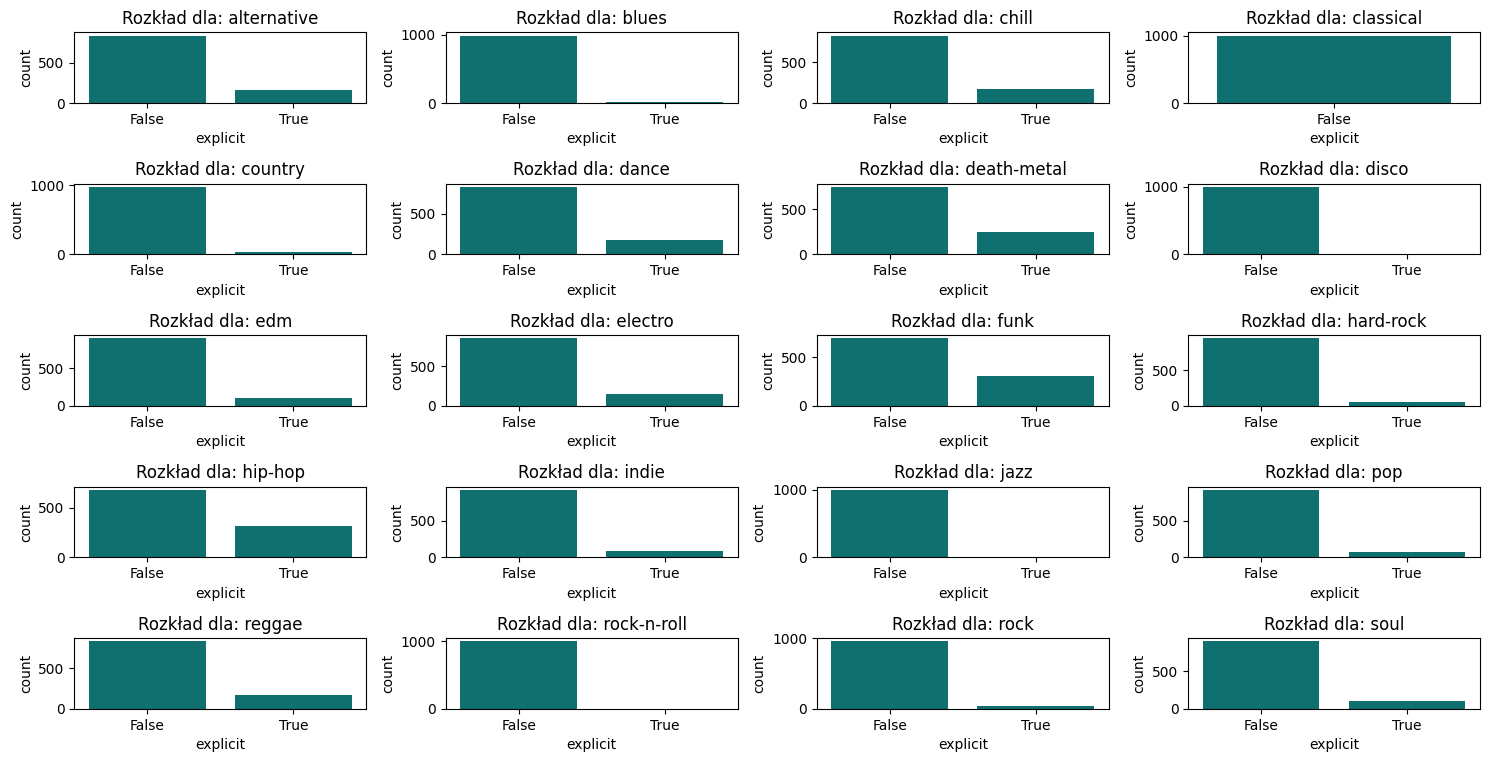

In [57]:
plt.figure(figsize=(15, 30))
for i, genre in enumerate(GENRES):
    plt.subplot(len(GENRES), 4, i + 1)
    sns.countplot(data=df[df['track_genre'] == genre], x='explicit', color='teal')
    plt.title(f"Rozkład dla: {genre}")
plt.tight_layout()
plt.show()

### Analiza rodzajów tonacji (dur/moll) dla gatunków muzyki

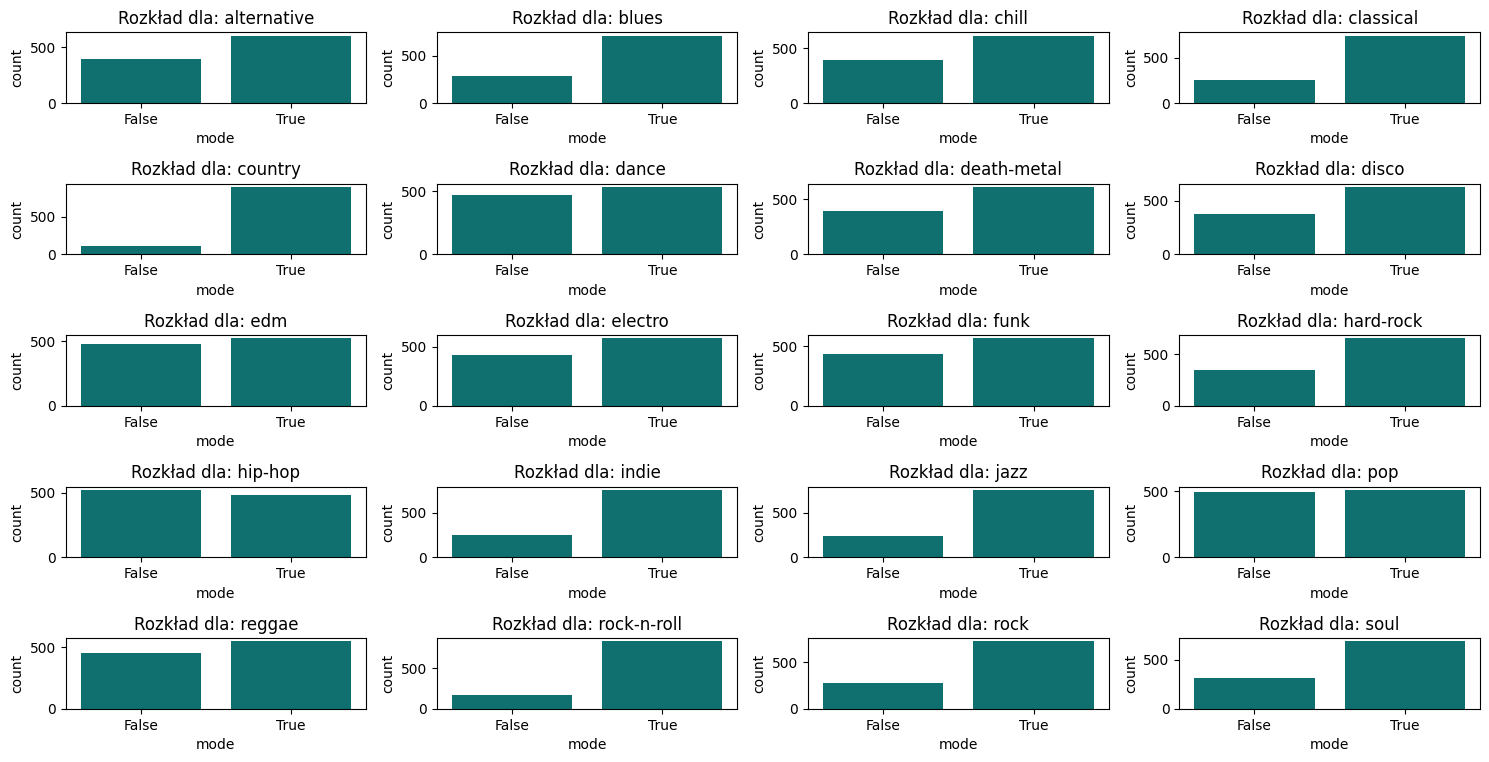

In [56]:
plt.figure(figsize=(15, 30))
for i, genre in enumerate(GENRES):
    plt.subplot(len(GENRES), 4, i + 1)
    sns.countplot(data=df[df['track_genre'] == genre], x='mode', color='teal')
    plt.title(f"Rozkład dla: {genre}")
plt.tight_layout()
plt.show()

# Modele uczenia maszynowego

# Interpretacja modeli

# Źródła

# Wykorzystane biblioteki oraz pakiety